# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d_x(t), v_x(t), d_y(t), v_y(t), \theta(t)]^T$, where $t$ specifies time. The control input of the rocket $a(t)$ includes its acceleration $a_1(t)$ and angular velocity $a_2(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
& d_x(t+1) = d_x(t) + v_x(t) \Delta t, \\
& v_x(t+1) = v_x(t) + a_1(t)sin(\theta(t)) \Delta t, \\
& d_y(t+1) = d_y(t) + v_y(t) \Delta t, \\
& v_y(t+1) = v_y(t) + a_1(t)cos(\theta(t)) \Delta t, \\
& \theta(t+1) = \theta(t) + a_2(t) \Delta t, \\
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d_x(T)^2 + v_x(T)^2 + d_y(T)^2 + v_y(T)^2 + \theta(T)^2$. This loss encourages the rocket to reach $x(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d_x(t+1) = d_x(t) + v_x(t) \Delta t, \\
\quad & v_x(t+1) = v_x(t) + a_1(t) sin(\theta(t)) \Delta t, \\
\quad & d_y(t+1) = d_y(t) + v_y(t) \Delta t, \\
\quad & v_y(t+1) = v_y(t) + a_1(t) cos(\theta(t)) \Delta t, \\
\quad & \theta(t+1) = \theta(t) + a_2(t) \Delta t, \\
\quad & [a(t), \omega(t)] = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

![Image](https://github.com/dayanbatuofu/MAE-598-Design-Optimization/raw/main/project1_demo/rocket%20landing.png)

In [2]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR # for learning rate
import scipy.io

logger = logging.getLogger(__name__)

# set seed for reproducability
torch.manual_seed(10)
torch.autograd.set_detect_anomaly(True)

In /home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 

In [3]:
# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
ROTATION_ACCEL = 20  # rotation constant

In [4]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = thrust controller
        action[1] = omega controller

        state[0] = x
        state[1] = x_dot
        state[2] = y
        state[3] = y_dot
        state[4] = theta
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        delta_state_gravity = torch.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])

        # Thrust
        # Note: Same reason as above. Need a 5-by-1 tensor.
        N = len(state)
        state_tensor = torch.zeros((N, 5))
        state_tensor[:, 1] = -torch.sin(state[:, 4])
        state_tensor[:, 3] = torch.cos(state[:, 4])
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[:, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, -1.]), action[:, 1].reshape(-1, 1))

        state = state + delta_state + delta_state_gravity + delta_state_theta

        # Update state
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0., 0.],
                                 [0., 1., 0., 0., 0.],
                                 [0., 0., 1., FRAME_TIME, 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)

        return state.T

In [20]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

In [21]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = torch.rand((N, 5))
        state[:, 1] = 0  # vx = 0
        state[:, 3] = 0  # vy = 0
        # TODO: need batch of initial states
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

In [22]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss_list = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.loss_list.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        for i in range(self.simulation.N):
            dx = data[i, :, 0]
            dy = data[i, :, 2]
            vx = data[i, :, 1]
            vy = data[i, :, 3]
            theta = data[i, :, 4]
            fig1, axs0 = plt.subplots()
            fig2, axs1 = plt.subplots()
            fig3, axs2 = plt.subplots()
            fig4, axs3 = plt.subplots()
            axs0.plot(dx, dy)
            axs0.set_title('Position Changeable for Rocket Landing')
            axs0.set_xlabel('Rocket X Position(m)')
            axs0.set_ylabel('Rocket Y Position(m)')

            axs1.plot(list(range(self.simulation.T)), vx)
            axs1.set_title('Velocity X Changeable for Rocket Landing')
            axs1.set_xlabel('Time Step')
            axs1.set_ylabel('Rocket X Velocity(m/s)')

            axs2.plot(list(range(self.simulation.T)), vy)
            axs2.set_title('Velocity Y Changeable for Rocket Landing')
            axs2.set_xlabel('Time Step')
            axs2.set_ylabel('Rocket Y Velocity(m/s)')

            axs3.plot(list(range(self.simulation.T)), theta)
            axs3.set_title('Theta Changeable for Rocket Landing')
            axs3.set_xlabel('Time Step')
            axs3.set_ylabel('Rocket Theta(rad)')
        plt.show()

/home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[1] loss: 2.398
[2] loss: 1.450
[3] loss: 1.051
[4] loss: 0.794
[5] loss: 0.611
[6] loss: 0.478
[7] loss: 0.350
[8] loss: 0.244
[9] loss: 0.165
[10] loss: 0.111
[11] loss: 0.071
[12] loss: 0.048
[13] loss: 0.034
[14] loss: 0.025
[15] loss: 0.019
[16] loss: 0.015
[17] loss: 0.011
[18] loss: 0.009
[19] loss: 0.008
[20] loss: 0.006
[21] loss: 0.005
[22] loss: 0.005
[23] loss: 0.004
[24] loss: 0.004
[25] loss: 0.003
[26] loss: 0.003
[27] loss: 0.003
[28] loss: 0.003
[29] loss: 0.003
[30] loss: 0.003
[31] loss: 0.002
[32] loss: 0.002
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.002
[38] loss: 0.002
[39] loss: 0.002
[40] loss: 0.002
[41] loss: 0.002
[42] loss: 0.002
[43] loss: 0.002
[44] loss: 0.002
[45] loss: 0.002
[46] loss: 0.002
[47] loss: 0.002
[48] loss: 0.002
[49] loss: 0.002
[50] loss: 0.002
[51] loss: 0.002
[52] loss: 0.002
[53] loss: 0.002
[54] loss: 0.002
[55] loss: 0.002
[56] loss: 0.002
[57] loss: 0.002
[58] loss: 0.002
[59] loss: 0.002
[60] l

/home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/doi6/miniconda3/envs/siren/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (T

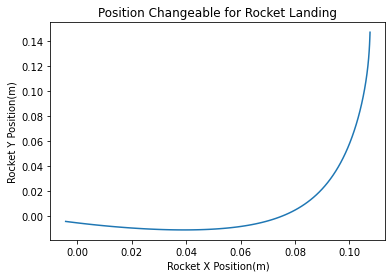

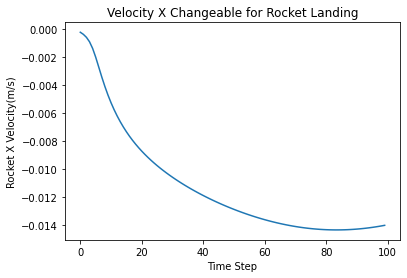

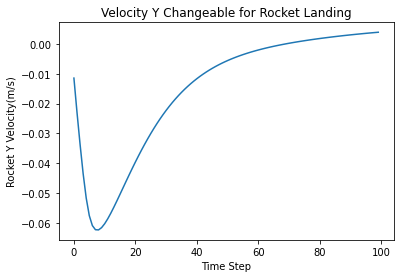

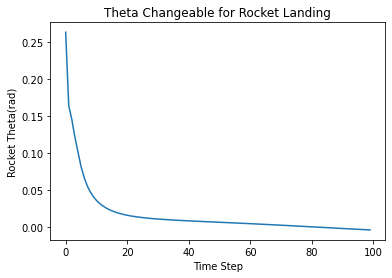

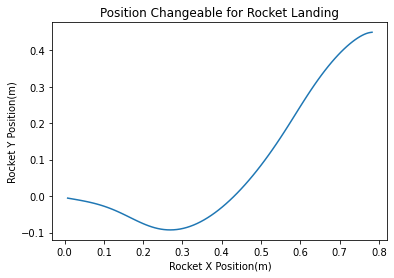

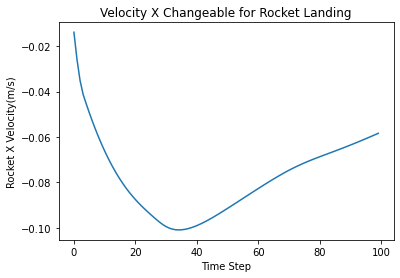

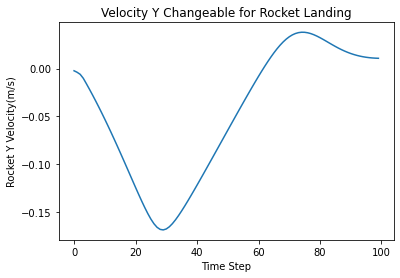

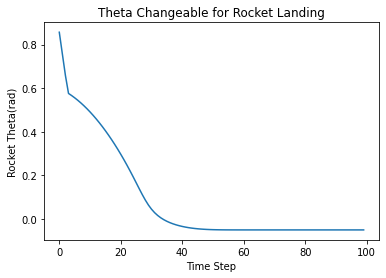

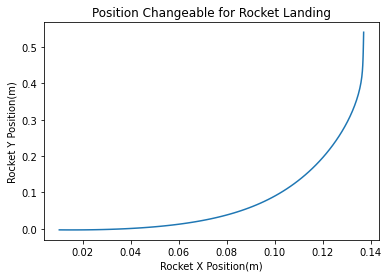

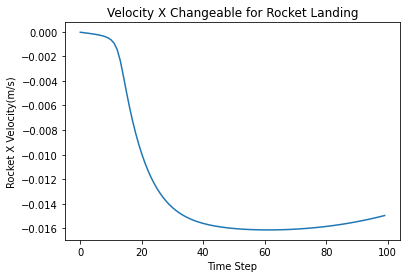

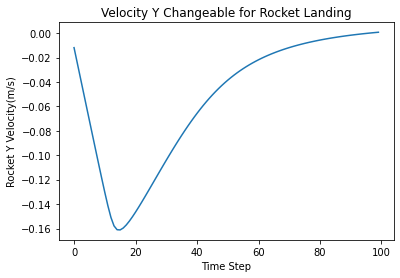

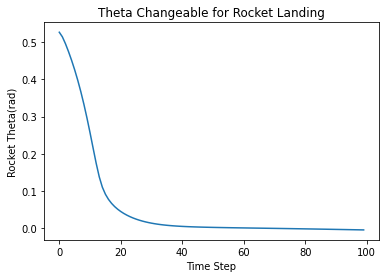

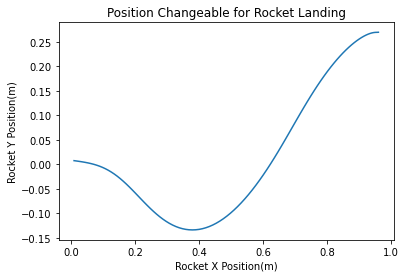

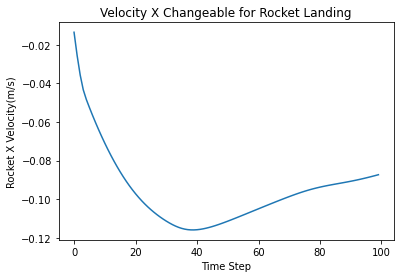

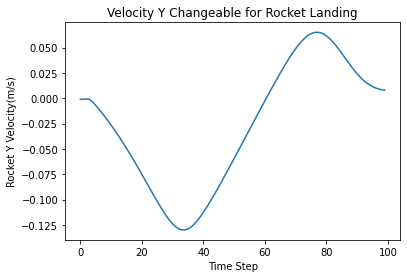

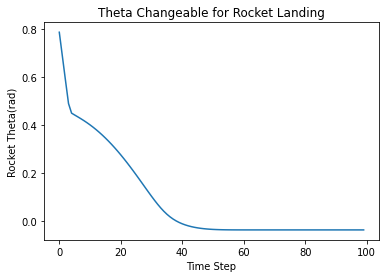

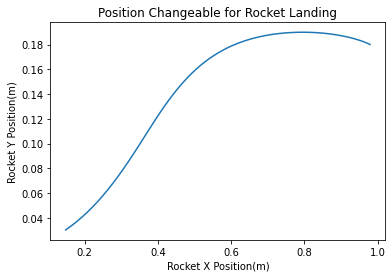

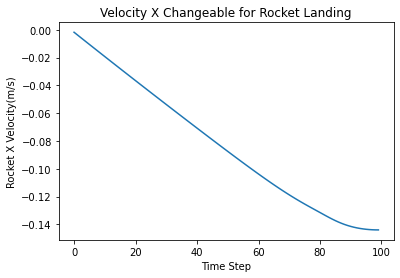

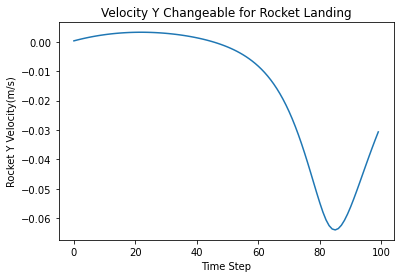

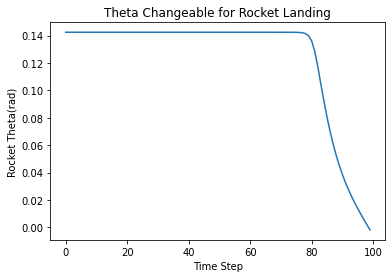

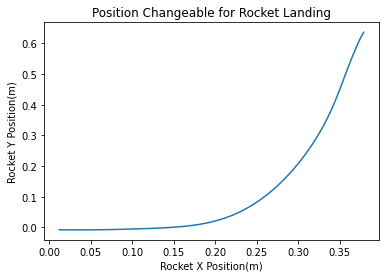

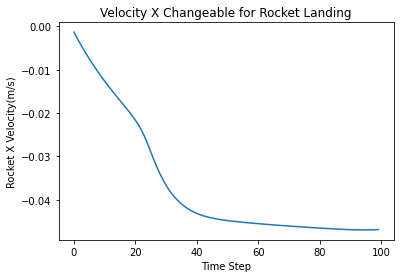

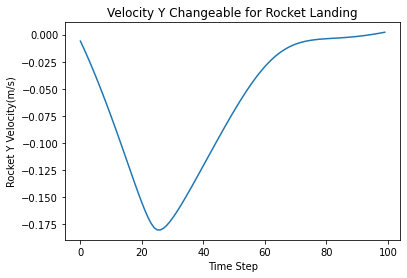

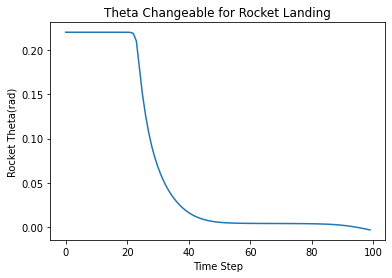

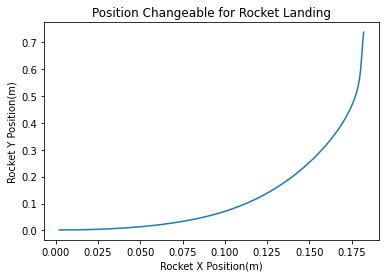

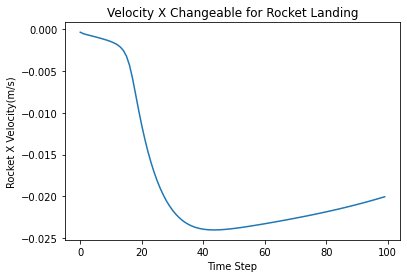

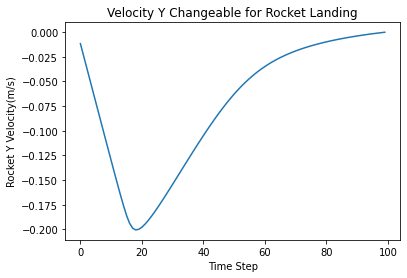

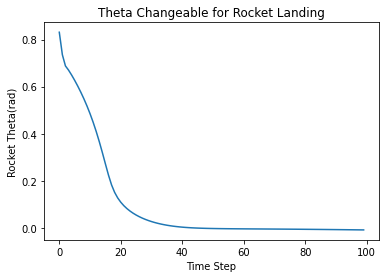

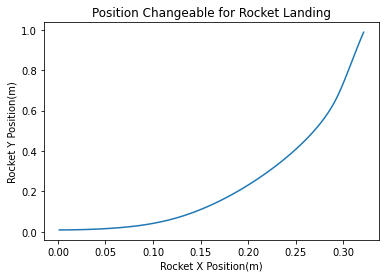

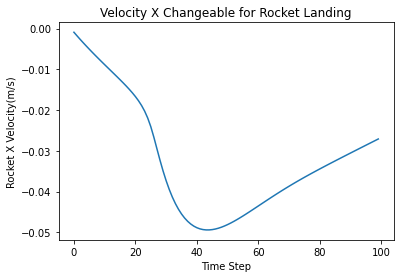

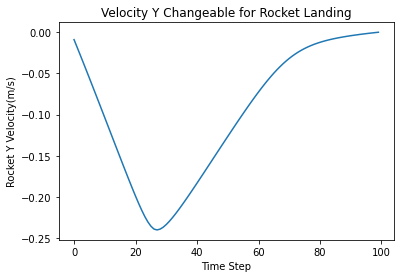

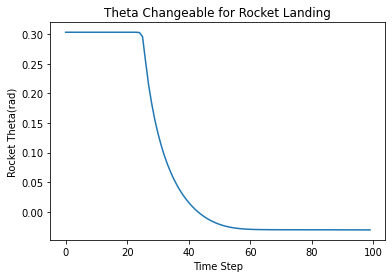

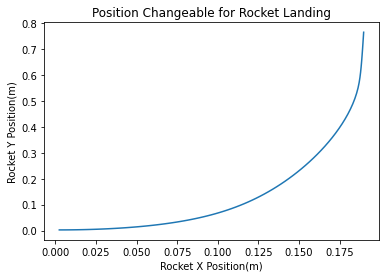

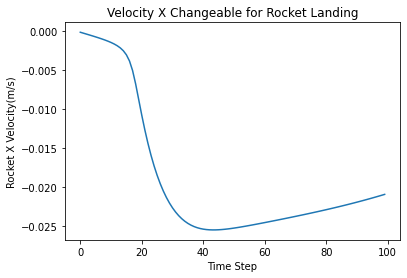

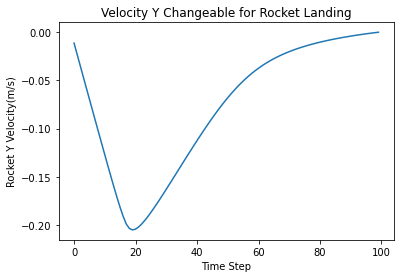

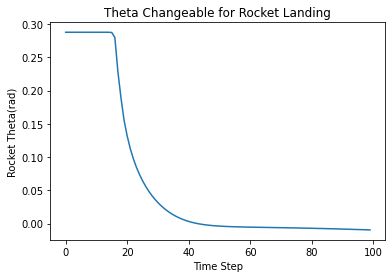

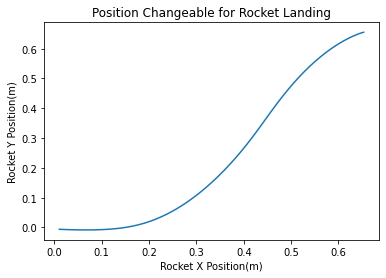

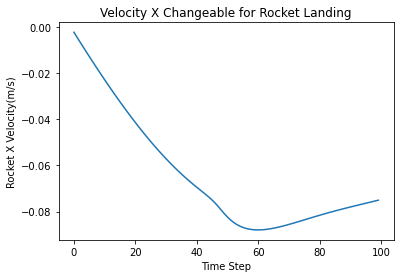

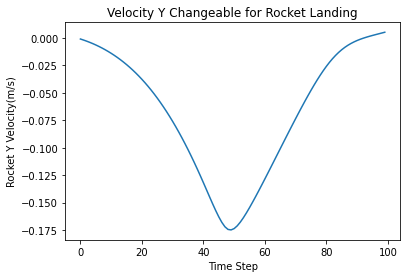

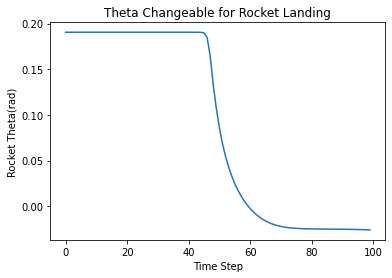

In [23]:
# Now it's time to run the code!

N = 10  # number of samples  for random case
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation, N is the number of samples to be considered
o = Optimize(s)  # define optimizer
o.train(80)  # solve the optimization problem

![Image](https://github.com/dayanbatuofu/MAE-598-Design-Optimization/raw/main/project1_demo/image_recording/movie_rocket_landing.gif)

## 3. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

In [ ]:
# Using Randomness



## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 